In [1]:
!nvidia-smi

Mon Mar 20 19:58:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import datetime
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

zip_ref = zipfile.ZipFile('pizza_steak.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2023-03-20 19:58:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   175MB/s    in 0.6s    

2023-03-20 19:58:17 (175 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [3]:
%load_ext tensorboard

In [4]:
import os

for dir_path, dirnames, filenames in os.walk('pizza_steak'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}')

There are 2 directories and 0 images in pizza_steak
There are 2 directories and 0 images in pizza_steak/train
There are 0 directories and 750 images in pizza_steak/train/steak
There are 0 directories and 750 images in pizza_steak/train/pizza
There are 2 directories and 0 images in pizza_steak/test
There are 0 directories and 250 images in pizza_steak/test/steak
There are 0 directories and 250 images in pizza_steak/test/pizza


In [5]:
import pathlib
data_dir = pathlib.Path('pizza_steak/train/')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['pizza', 'steak'], dtype='<U5')

In [6]:
import matplotlib.image as mpimg
import random

def view_random(target_dir, target_class):
  target_folder = target_dir+target_class
  rand_image = random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder+'/'+rand_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image Shape: {img.shape}')
  return img

Image Shape: (341, 512, 3)


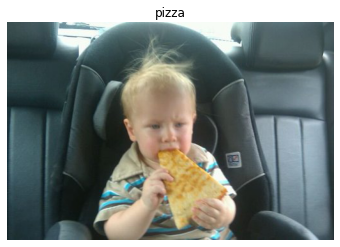

In [7]:
img_pizza = view_random(target_dir = 'pizza_steak/train/', target_class = 'pizza')


Image Shape: (307, 512, 3)


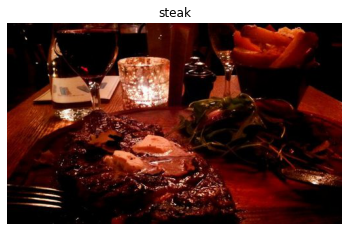

In [8]:
img_steak = view_random(target_dir = 'pizza_steak/train/', target_class = 'steak')

In [9]:
img_pizza = img_pizza/255.
img_steak = img_steak/255.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_data = train_datagen.flow_from_directory(
    train_dir, batch_size = 32, target_size = (224,224), class_mode = "binary", seed= 42
)

test_data = train_datagen.flow_from_directory(
    test_dir, batch_size = 32, target_size = (224,224), class_mode = "binary", seed= 42
)

model_1 = Sequential([
    Conv2D(filters = 10, kernel_size = 3, activation = 'relu', input_shape = (224,224, 3)),
    Conv2D(10,3, activation = 'relu'),
    MaxPool2D(pool_size =2, padding = 'valid'),
    Conv2D(10,3, activation = 'relu'),
    Conv2D(10,3, activation = 'relu'),
    MaxPool2D(pool_size =2, padding = 'valid'),
    Flatten(),
    Dense(1, activation  = 'sigmoid')
])

model_1.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        callbacks=[tensorboard_callback])

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 28s 271ms/step - loss: 0.6492 - accuracy: 0.6180 - val_loss: 0.4732 - val_accuracy: 0.8200
Epoch 2/5
47/47 [==============================] - 10s 218ms/step - loss: 0.4582 - accuracy: 0.7893 - val_loss: 0.4009 - val_accuracy: 0.8480
Epoch 3/5
47/47 [==============================] - 10s 220ms/step - loss: 0.4064 - accuracy: 0.8127 - val_loss: 0.3363 - val_accuracy: 0.8620
Epoch 4/5
47/47 [==============================] - 12s 267ms/step - loss: 0.3869 - accuracy: 0.8427 - val_loss: 0.3211 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 16s 350ms/step - loss: 0.3477 - accuracy: 0.8560 - val_loss: 0.3473 - val_accuracy: 0.8660


In [11]:
# !tensorboard dev upload --logdir logs --name "CNN Experiment" --description "Food datasets" 

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

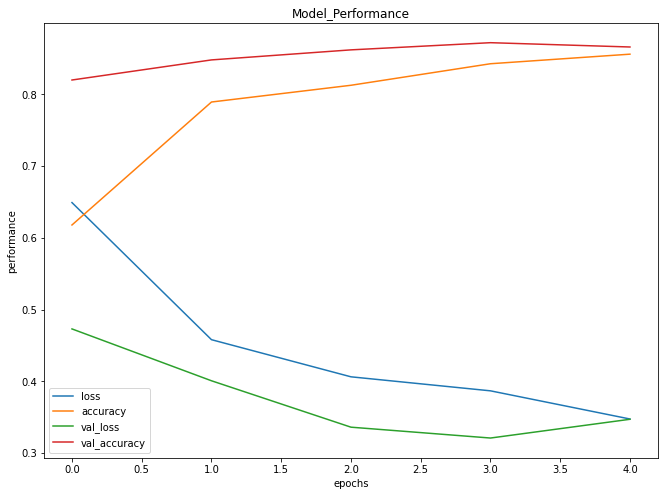

In [13]:
def plot_history(hist):
  model_history = pd.DataFrame(hist.history)
  model_history.plot(figsize=(11,8), title = 'Model_Performance', xlabel = 'epochs', ylabel = 'performance')

plot_history(history_1)

In [14]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20)
test_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20)

train_data = train_datagen.flow_from_directory(
    train_dir, batch_size = 32, target_size = (224,224), class_mode = "binary", seed= 42
)

test_data = train_datagen.flow_from_directory(
    test_dir, batch_size = 32, target_size = (224,224), class_mode = "binary", seed= 42
)

model_2 = Sequential([
    Conv2D(filters = 10, kernel_size = 3, activation = 'relu', input_shape = (224,224, 3)),
    Conv2D(10,3, activation = 'relu'),
    MaxPool2D(pool_size =2, padding = 'valid'),
    Conv2D(10,3, activation = 'relu'),
    Conv2D(10,3, activation = 'relu'),
    MaxPool2D(pool_size =2, padding = 'valid'),
    Flatten(),
    Dense(1, activation  = 'sigmoid')
])

model_2.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)




history_2 = model_2.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 32s 606ms/step - loss: 0.6309 - accuracy: 0.6633 - val_loss: 0.5143 - val_accuracy: 0.7380
Epoch 2/5
47/47 [==============================] - 29s 617ms/step - loss: 0.4738 - accuracy: 0.7773 - val_loss: 0.3910 - val_accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 28s 603ms/step - loss: 0.4423 - accuracy: 0.8007 - val_loss: 0.3782 - val_accuracy: 0.8480
Epoch 4/5
47/47 [==============================] - 38s 814ms/step - loss: 0.4333 - accuracy: 0.8060 - val_loss: 0.3441 - val_accuracy: 0.8600
Epoch 5/5
47/47 [==============================] - 33s 718ms/step - loss: 0.4131 - accuracy: 0.8160 - val_loss: 0.3464 - val_accuracy: 0.8420


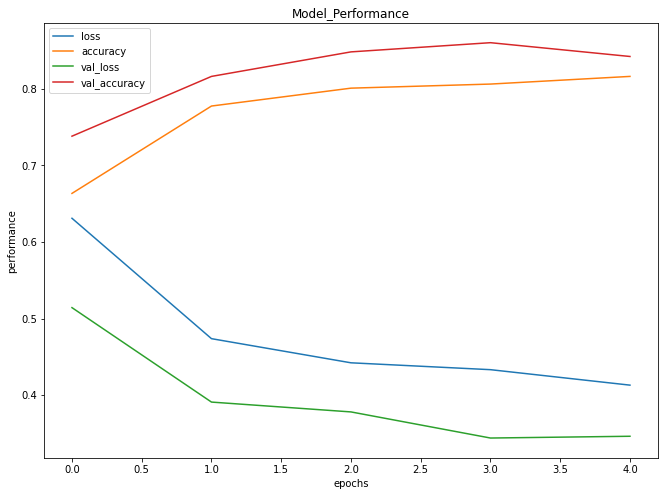

In [15]:
plot_history(history_2)

In [17]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True)

train_data = train_datagen.flow_from_directory(
    train_dir, batch_size = 32, target_size = (224,224), class_mode = "binary", seed= 42
)

test_data = train_datagen.flow_from_directory(
    test_dir, batch_size = 32, target_size = (224,224), class_mode = "binary", seed= 42
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [18]:
model_3 = Sequential([
    Conv2D(10, 3, activation = 'relu', input_shape= (224, 224,3)),
    MaxPool2D(pool_size = 2),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(),
    Conv2D(10,3, activation ='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation = 'sigmoid')
    
    
])

model_3.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [19]:
history_3 = model_3.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data)
)

Epoch 1/5
47/47 [==============================] - 41s 817ms/step - loss: 0.6621 - accuracy: 0.5887 - val_loss: 0.6140 - val_accuracy: 0.6580
Epoch 2/5
47/47 [==============================] - 30s 631ms/step - loss: 0.5629 - accuracy: 0.7127 - val_loss: 0.4732 - val_accuracy: 0.7700
Epoch 3/5
47/47 [==============================] - 32s 679ms/step - loss: 0.5042 - accuracy: 0.7607 - val_loss: 0.4376 - val_accuracy: 0.8020
Epoch 4/5
47/47 [==============================] - 30s 641ms/step - loss: 0.4889 - accuracy: 0.7720 - val_loss: 0.4180 - val_accuracy: 0.8200
Epoch 5/5
47/47 [==============================] - 29s 620ms/step - loss: 0.4725 - accuracy: 0.7753 - val_loss: 0.3927 - val_accuracy: 0.8300


In [20]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 10)      

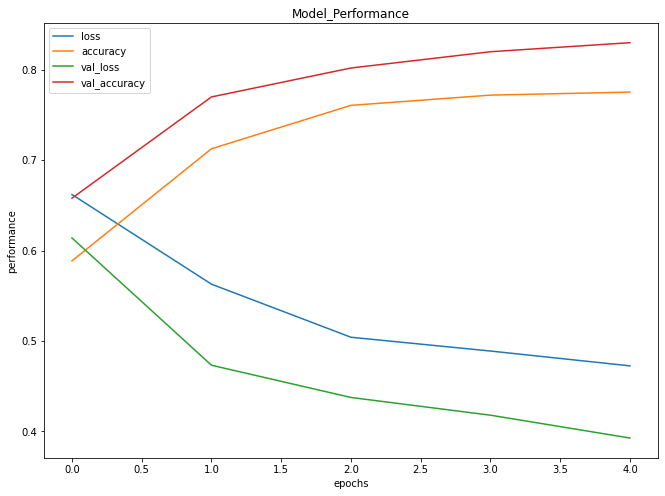

In [21]:
plot_history(history_3)

In [144]:
model_9 = Sequential([
    Conv2D(16, 2, activation = 'relu', input_shape= (224, 224,3)),
    Conv2D(16, 2, activation = 'relu'),

    MaxPool2D(pool_size = 2, padding = 'same'),
    Conv2D(16, 2, activation = 'relu'),
    Conv2D(16, 2, activation = 'relu'),
 
    MaxPool2D(pool_size = 2, padding = 'same'),
    Flatten(),
    Dense(1, activation = 'sigmoid')
    
    
])

model_9.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [145]:
history_9 = model_9.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data)
)

Epoch 1/5
47/47 [==============================] - 31s 607ms/step - loss: 0.6096 - accuracy: 0.6573 - val_loss: 0.4642 - val_accuracy: 0.7900
Epoch 2/5
47/47 [==============================] - 32s 678ms/step - loss: 0.5238 - accuracy: 0.7467 - val_loss: 0.4545 - val_accuracy: 0.7940
Epoch 3/5
47/47 [==============================] - 28s 595ms/step - loss: 0.4754 - accuracy: 0.7767 - val_loss: 0.4297 - val_accuracy: 0.8100
Epoch 4/5
47/47 [==============================] - 28s 594ms/step - loss: 0.4796 - accuracy: 0.7740 - val_loss: 0.3995 - val_accuracy: 0.8120
Epoch 5/5
47/47 [==============================] - 29s 613ms/step - loss: 0.4535 - accuracy: 0.7933 - val_loss: 0.3632 - val_accuracy: 0.8420


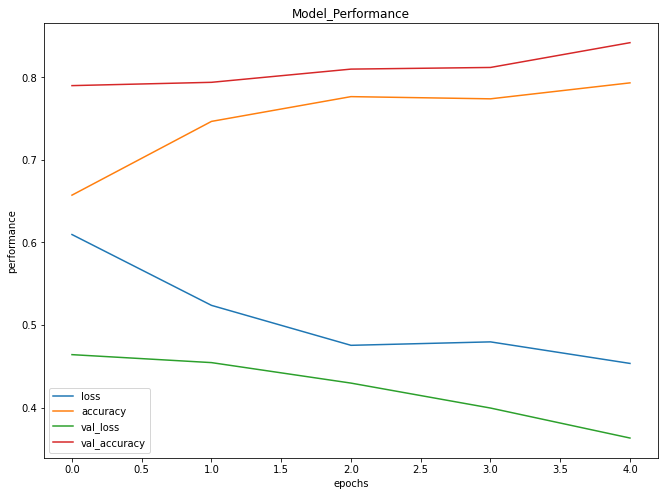

In [146]:
plot_history(history_9)

In [147]:
model_9.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 223, 223, 16)      208       
                                                                 
 conv2d_38 (Conv2D)          (None, 222, 222, 16)      1040      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 110, 110, 16)      1040      
                                                                 
 conv2d_40 (Conv2D)          (None, 109, 109, 16)      1040      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 55, 55, 16)       0         
 g2D)                                                 

In [123]:
def pred_file_random(model_name, class_val):  
  input_val= input()
  if input_val == 'pizza':
    img_pred = view_random(target_dir = 'pizza_steak/test/', target_class = input_val)
  elif input_val == 'steak':
    img_pred = view_random(target_dir = 'pizza_steak/test/', target_class = input_val)
  else:
    img_pred = mpimg.imread(input_val)
    plt.imshow(img_pred)
    plt.axis('off')
  img = tf.image.resize(img_pred, size = (224,224))
  img = img/.255
  img = tf.expand_dims(img, axis = 0)
  pred_val = model_name.predict(img)
  print(pred_val)
  print(f'Predicted Class = {class_val[int(tf.round(pred_val))]}')



/content/images.jpeg
1/1 [==============================] - 0s 21ms/step
[[1.]]
Predicted Class = steak


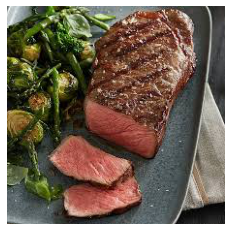

In [149]:
pred_file_random(model_9, class_names)



In [150]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-03-20 21:22:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   148MB/s    in 3.3s    

2023-03-20 21:22:49 (148 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [151]:
for dirpath, dirnames, filenames in os.walk('10_food_classes_all_data'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.

In [152]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"


In [153]:
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image Shape: (512, 512, 3)


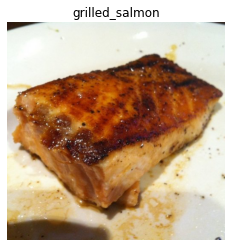

In [155]:
img = view_random(target_dir=train_dir,
                        target_class=random.choice(class_names))

In [156]:
train_data = train_datagen.flow_from_directory(
    train_dir, batch_size = 32, target_size = (224,224), class_mode = "categorical", seed= 42
)

test_data = train_datagen.flow_from_directory(
    test_dir, batch_size = 32, target_size = (224,224), class_mode = "categorical", seed= 42
)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [161]:
model_10 = Sequential([
    Conv2D(32, 3, activation = 'relu', input_shape = (224,224,3)),
    Conv2D(32, 3, activation = 'relu'),
    MaxPool2D(pool_size= 2),
    Conv2D(32, 3, activation = 'relu'),
    Conv2D(32, 3, activation = 'relu'),
    MaxPool2D(pool_size= 2),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

model_10.compile(loss = 'categorical_crossentropy',
                 optimizer = 'Adam',
                 metrics = ['accuracy'])

In [162]:
history_10 = model_10.fit(
    train_data,
    epochs = 5,
    validation_data = test_data,
    steps_per_epoch = len(train_data),
    validation_steps = len(test_data)
)

Epoch 1/5
235/235 [==============================] - 154s 642ms/step - loss: 2.2755 - accuracy: 0.1647 - val_loss: 2.1799 - val_accuracy: 0.1776
Epoch 2/5
235/235 [==============================] - 143s 609ms/step - loss: 2.1497 - accuracy: 0.2061 - val_loss: 2.0595 - val_accuracy: 0.2420
Epoch 3/5
235/235 [==============================] - 144s 613ms/step - loss: 2.1146 - accuracy: 0.2352 - val_loss: 2.0269 - val_accuracy: 0.2656
Epoch 4/5
235/235 [==============================] - 144s 613ms/step - loss: 2.0604 - accuracy: 0.2592 - val_loss: 2.0321 - val_accuracy: 0.2616
Epoch 5/5
235/235 [==============================] - 144s 614ms/step - loss: 2.0102 - accuracy: 0.2873 - val_loss: 1.9723 - val_accuracy: 0.3056


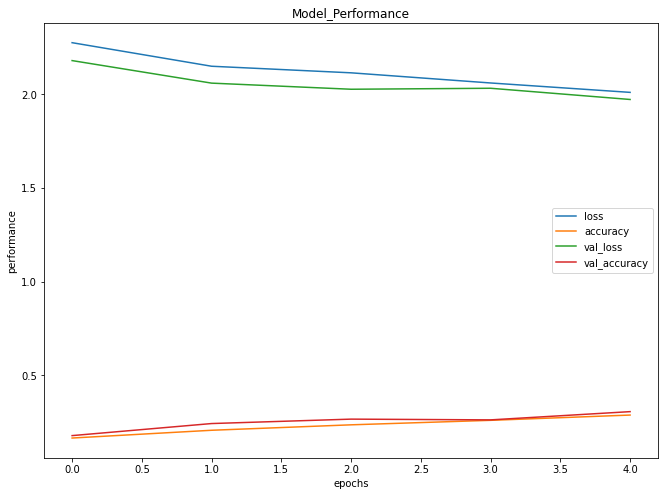

In [163]:
plot_history(history_10)

In [166]:
model_10.save("30_trained_model.h5")